In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import timeit
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

%load_ext tensorboard

print("Using TensorFlow version %s" % tf.__version__)
#import tensorflow.experimental.numpy as tnp

Using TensorFlow version 2.5.0-dev20210101


In [2]:
# Use layers to make layers or block
# make a model using those layers then

# layers = state + forward_pass (subclass layers)
# block = set of layers (subclass layers)
# model = set of block/layers (subclass model)

# Q) Need model.fit, model.evaluate, model.predict(), save(), save_weights() -> use keras.model

class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class ActivityRegularizationLayer(keras.layers.Layer):
    def __init__(self, rate=1e-2):
        super(ActivityRegularizationLayer, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(inputs))
        return inputs    
    
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)
    
class MLPBlock(keras.layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.dense = keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-3))
        self.activity_reg = ActivityRegularizationLayer(1e-2)
        self.linear_3 = Linear(1)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        x = self.dense(x)
        x = self.activity_reg(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print("weights:", len(mlp.weights))
print("trainable weights:", len(mlp.trainable_weights))    
mlp.losses

#----------------
# using these losses in a training loop

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Iterate over the batches of a dataset.
for x_batch_train, y_batch_train in train_dataset:
    with tf.GradientTape() as tape:
        logits = layer(x_batch_train)  # Logits for this minibatch
        # Loss value for this minibatch
        loss_value = loss_fn(y_batch_train, logits)
        # Add extra losses created during this forward pass:
        loss_value += sum(model.losses)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
#-----------------------
# using these losses in model.fit()

import numpy as np

inputs = keras.Input(shape=(3,))
outputs = ActivityRegularizationLayer()(inputs)
model = keras.Model(inputs, outputs)

# If there is a loss passed in `compile`, thee regularization
# losses get added to it
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# It's also possible not to pass any loss in `compile`,
# since the model already has a loss to minimize, via the `add_loss`
# call during the forward pass!
model.compile(optimizer="adam")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

#-------------------------------
# add_metric in a layer and use latter in model.fit()

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

weights: 8
trainable weights: 8


[<tf.Tensor: shape=(), dtype=float32, numpy=0.03153436>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.013410017>]

NameError: name 'train_dataset' is not defined

In [ ]:
# Privileged 'training' argument in the call() method of a custom layer
# Helps to account in casses where layers needs to be there only for trainigs and not for evaluation like BtachNormalization, Dropout

class CustomDropout(keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return tf.nn.dropout(inputs, rate=self.rate)
        return inputs
    
# Privileged mask argument in the call() method --> RNN    

In [ ]:
# model = concatenate block of layers

class ResNet(tf.keras.Model):

    def __init__(self):
        super(ResNet, self).__init__()
        self.block_1 = ResNetBlock()
        self.block_2 = ResNetBlock()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = Dense(num_classes)

    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.global_pool(x)
        return self.classifier(x)


resnet = ResNet()
dataset = ...
resnet.fit(dataset, epochs=10)
resnet.save(filepath)

In [16]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
for step, i in enumerate(train_dataset):
    print(i.shape)
step    

(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)
(64, 784)


937

In [17]:
60000/64

937.5

In [22]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



original_dim = 784
intermediate_dim = 64
latent_dim = 32

# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu", name='first_layer_decoder')(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
vae.fit(x_train, x_train, epochs=3, batch_size=64)

Epoch 1/3
938/938 [==============================] - 4s 5ms/step - loss: 0.0747
Epoch 2/3
938/938 [==============================] - 6s 7ms/step - loss: 0.0676
Epoch 3/3
938/938 [==============================] - 5s 6ms/step - loss: 0.0676


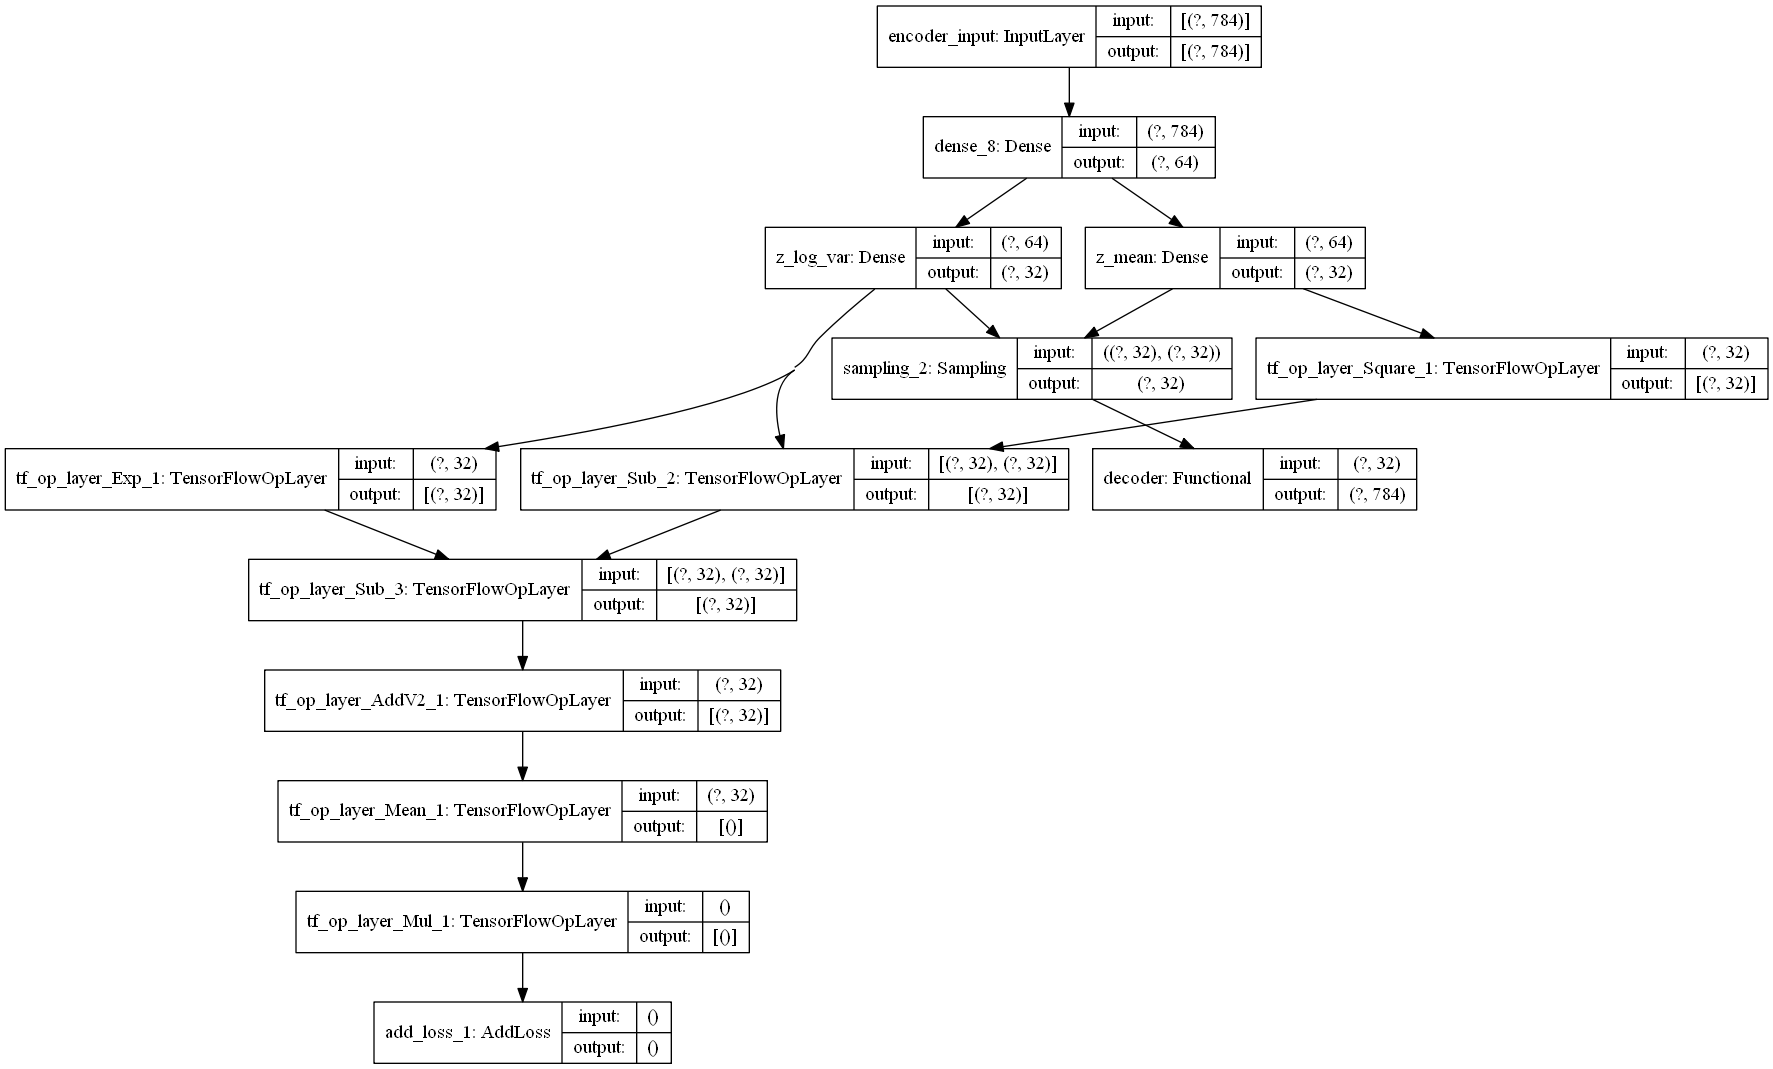

In [23]:
keras.utils.plot_model(vae, "vae.png", show_shapes=True)
